# Questions

* Should I calculate business days since incident? or Total days?
* How to do timeseries?
  * Only predict a date based on the info that's happened BEFORE it?
  * Book by week? exact day of year? month?
 ---
* Could I make an EITHER/OR case?
  * First do a classifier for Compensate or Deny. If compensate, then do a Regression for HOW MUCH they'll get back?
  * I could also do models that ONLY take into account how much they asked for, IF I have enough data
* Why is my RF 410 MB?
* **I may be parsing 'ITEMS' wrong. Semicolon may indicate the various items missing**

### 1st simple model, "settle" or "compensate" I got 67.40% ROC!
### 2nd model, with claim_request_amount, roc_auc got 68.64%

# Next Steps
* Try a Rolling Window of 12 months to remove seasonality and see if there are changes from 2002 onward
* See if I can spot trends by day/week/month/holidays/weekends during the year

### *Is it an issue with 370 airports and 170 airlines?*
### I should consider dropping some of the claim_types and maybe other stuff too

# Feature engineer count of how many claims

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyspark

import datetime as dt

import tabula
import joblib

In [22]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE

In [3]:
dir = 'models/preliminary'

-----

-----

In [4]:
col_names = ['claim_number', 'date_received', 'incident_date', 'airport_code', 'airport_name',
           'airline', 'claim_type', 'claim_site', 'item_category', 'close_amount', 'disposition']
           

In [5]:
df = pd.read_excel('raw/claims-2010-2013.xls', names=col_names)

df['date_received'] = pd.to_datetime(df['date_received'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df = df[df['disposition'] != "-"]
df = df.dropna()

df['claim_number'] = df['claim_number'].astype('int64')
df['close_amount'] = df['close_amount'].astype('int64')

FileNotFoundError: [Errno 2] No such file or directory: 'raw/claims-2010-2013.xls'

In [6]:
df['binary_disposition'] = df['disposition']
df['binary_disposition'] = df['binary_disposition'].where(df['binary_disposition'] == 'Deny', other='Compensate')

# Change some text to make it more human readable
df.claim_site[df.claim_site == '-'] = 'Unknown'
df.claim_type[df.claim_type == '-'] = 'Unknown'

# Feature Engineering

### Count of items claimed

# TODO: Consider only using this for where claim_type is related to property.
df['num_items_or_incidents_claimed'] = df['item_category'].str.split(pat=';').apply(lambda x: len(x))
df['num_items_or_incidents_claimed'] = df['num_items_or_incidents_claimed'].where(df['claim_type'].str.contains('property', case=False) == True, other= 0)

### Time calculation
wait_period = df.date_received - df.incident_date
df['days_waited_to_file_claim'] = wait_period.dt.days

# Drop days where the 'date_received" was reported before 'incident_date'
df = df[df.days_waited_to_file_claim >= 0]

df.reset_index(inplace=True,drop=True)
df['bin_dispos_onehot'] = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

NameError: name 'df' is not defined

In [7]:
## Figure out how to plot this shit. I want 12 months on the X axis, and then a bar for each month of the proportion of approved vs denied within each month (I think)

# TIME BREAKOUT COLUMNS

In [8]:
df['Week/Year_inc_date'] = df['incident_date'].apply(lambda x: "%d/%d" % (x.week, x.year))
df['Week_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.week))
df['Month_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.month))
df['Year_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.year))

df['Week_received'] = df['date_received'].apply(lambda x: "%d" % (x.week))
df['Month_received'] = df['date_received'].apply(lambda x: "%d" % (x.month))
df['Year_received'] = df['date_received'].apply(lambda x: "%d" % (x.year))

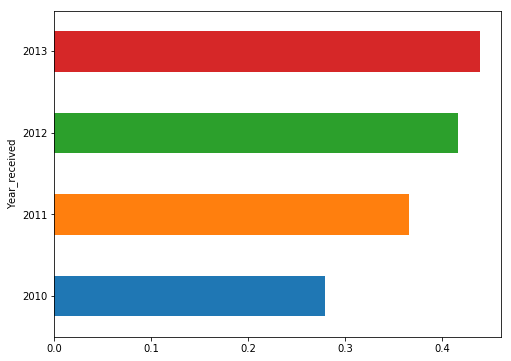

In [9]:
df.groupby('Year_received').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6))

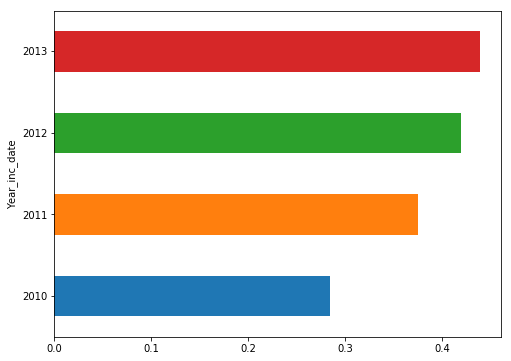

In [10]:
df.groupby('Year_inc_date').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

In [11]:
df.sample(3)

,claim_number,date_received,incident_date,airport_code,airport_name,airline,claim_type,claim_site,item_category,close_amount,disposition,binary_disposition,num_items_or_incidents_claimed,days_waited_to_file_claim,bin_dispos_onehot,Week/Year_inc_date,Week_inc_date,Month_inc_date,Year_inc_date,Week_received,Month_received,Year_received
15911,2011093087276,2011-08-15,2011-05-19 00:00:00,MEM,Memphis International Airport,Delta Air Lines,Personal Injury,Checkpoint,Medical/Science,0,Deny,Deny,0,88,0,20/2011,20,5,2011,33,8,2011
28523,2013020601073,2013-01-10,2013-01-04 00:00:00,SAN,San Diego International,USAir,Passenger Property Loss,Checked Baggage,Cosmetics & Grooming,0,Deny,Deny,1,6,0,1/2013,1,1,2013,2,1,2013
4725,2010072173938,2010-07-12,2010-07-10 20:00:00,LAS,McCarran International,Continental Airlines,Property Damage,Checked Baggage,Baggage/Cases/Purses; Clothing; Clothing; Clot...,0,Deny,Deny,8,1,0,27/2010,27,7,2010,28,7,2010


In [12]:
# df_simple = df.drop(['claim_number', 'airport_name', 
#                      #'binary_disposition',
#                      'disposition', 
#                      'date_received', 'incident_date'
#                     ]
#                     , axis=1)

In [13]:
X = df.drop(['claim_number', 'airport_name', 'binary_disposition', 'disposition', 
             'date_received', 'incident_date',
             'close_amount',
            ]
            , axis=1)
y = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

In [14]:
categorical = ['airport_code', 'airline', 'claim_type', 'claim_site', 'Year_inc_date']
continuous =  ['days_waited_to_file_claim', 'num_items_or_incidents_claimed']

In [15]:
enc = OneHotEncoder(sparse=False)
onehotarray = enc.fit_transform(X[categorical])

ss = StandardScaler()
continuousarray = ss.fit_transform(X[continuous])

mlb = MultiLabelBinarizer(sparse_output=False)
onehot_itemcategories = mlb.fit_transform(X['item_category'].str.replace(' ','').str.split(pat=';'))

X = np.concatenate((onehotarray, continuousarray, onehot_itemcategories), axis=1)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [17]:
X.shape

(34478, 610)

# Model with Year included

---
some problems with this would be introducing YEAR and MONTH that has never been trained on. Is this where I need to do a timeseries thing

---

In [20]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini']#, 'entropy']
n_ests = [300]
m_depths = [20, 25, 30, 35]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests, max_depth=m_depths)

grid_rf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=8, n_jobs=4)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

y_pred = grid_rf.predict(X_test)
print(roc_auc_score(y_test, y_pred))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/ex

0.7357708102376144
{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.6232068609575628


In [21]:
dir = 'models/preliminary'
joblib.dump(grid_rf.best_estimator_, f'{dir}/rf_Year_of_incident_date_included',compress=9)

['models/preliminary/rf_Year_of_incident_date_included']

# Model below was BEFORE I added time elements

In [196]:
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=5, random_state=42)
cvs = cross_val_score(rf_clf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(cvs))

0.6814186309902636


In [199]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [203]:
y_predict = rf_clf.predict(X_test)

roc_auc_score(y_test, y_predict)

In [ ]:
# make a schedule from now til Thursday
# make change max_depth to [3, 5, 10] to see which works best if i am overfitting

In [204]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini']#, 'entropy']
n_ests = [300]
m_depths = [15, 20, 25]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests, max_depth=m_depths)

grid_rf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=8, n_jobs=4)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

y_pred = grid_rf.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.7220751078811192
{'criterion': 'gini', 'max_depth': 15, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.5953619560289024


In [209]:
dir = 'models/preliminary'
joblib.dump(grid_rf.best_estimator_, f'{dir}/rf_mdepth_15',compress=9)

['models/preliminary/rf_mdepth_15']

In [206]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini']#, 'entropy']
n_ests = [300]
m_depths = [10, 15, 20]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests, max_depth=m_depths)

grid_rf3 = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=8, n_jobs=4)

grid_rf3.fit(X_train, y_train)

print(grid_rf3.best_score_)
print(grid_rf3.best_params_)
print(grid_rf3.best_estimator_)

y_pred3 = grid_rf3.predict(X_test)
print(roc_auc_score(y_test, y_pred3))

0.725709095769306
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.6062968483199722


In [516]:
dir = 'models/preliminary'
joblib.dump(grid_rf.best_estimator_, f'{dir}/rf_without_dates_or_requested_amount', compress=9)

['models/preliminary/rf_without_dates_or_requested_amount']

# Load for test run

In [3]:
import pickle

In [4]:
cleandir = 'data/clean'
df = pd.read_pickle(f'{cleandir}/clean_for_classifier_df.pkl')

In [5]:
df.head()

,date_received,incident_date,airport_code,airline,claim_type,claim_site,close_amount,disposition,item_category
217668,2017-12-01,2017-11-30 00:00:00,MCO,Westjet Airlines Ltd,PropertyLoss,Checkpoint,17.990,Approve in Full,Household Items
216902,2017-11-28,2017-10-22 00:00:00,LAS,UAL,PropertyLoss,Checked Baggage,90.000,Settle,Clothing
217268,2017-11-20,2017-09-29 12:20:00,LAX,American Airlines,PropertyDamage,Checkpoint,485.550,Settle,Computer & Accessories
215386,2017-10-26,2017-10-10 21:10:00,FLL,Emirates,PropertyLoss,Checked Baggage,111.300,Approve in Full,Other
218413,2017-10-25,2017-05-17 00:00:00,MIA,American Airlines,PropertyLoss,Checked Baggage,65.000,Approve in Full,Baggage/Cases/Purses; Clothing


In [48]:
example

{'airport_code': 'SEA',
 'airline': 'Emirates',
 'claim_type': 'PropertyLoss',
 'claim_site': 'Checkpoint',
 'item_category': 'Clothing',
 'num_items_or_incidents_claimed': 1,
 'days_waited_to_file_claim': 7,
 'Month_received': 1}

In [6]:
df['binary_disposition'] = df['disposition']
df['binary_disposition'] = df['binary_disposition'].where(df['binary_disposition'] == 'Deny', other='Compensate')

# Change some text to make it more human readable
df.claim_site[df.claim_site == '-'] = 'Unknown'
df.claim_type[df.claim_type == '-'] = 'Unknown'

# Feature Engineering

### Count of items claimed

# TODO: Consider only using this for where claim_type is related to property.
df['num_items_or_incidents_claimed'] = df['item_category'].str.split(pat=';').apply(lambda x: len(x))
df['num_items_or_incidents_claimed'] = df['num_items_or_incidents_claimed'].where(df['claim_type'].str.contains('property', case=False) == True, other= 0)

### Time calculation
wait_period = df.date_received - df.incident_date
df['days_waited_to_file_claim'] = wait_period.dt.days

# Drop days where the 'date_received" was reported before 'incident_date'
df = df[df.days_waited_to_file_claim >= 0]

df.reset_index(inplace=True,drop=True)
df['bin_dispos_onehot'] = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
## Figure out how to plot this shit. I want 12 months on the X axis, and then a bar for each month of the proportion of approved vs denied within each month (I think)

# TIME BREAKOUT COLUMNS

In [7]:
# df['Week/Year_inc_date'] = df['incident_date'].apply(lambda x: "%d/%d" % (x.week, x.year))
# df['Week_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.week))
# df['Month_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.month))
# df['Year_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.year))

# df['Week_received'] = df['date_received'].apply(lambda x: "%d" % (x.week))
df['Month_received'] = df['date_received'].apply(lambda x: "%d" % (x.month))
# df['Year_received'] = df['date_received'].apply(lambda x: "%d" % (x.year))

In [8]:
df.head()

,date_received,incident_date,airport_code,airline,claim_type,claim_site,close_amount,disposition,item_category,binary_disposition,num_items_or_incidents_claimed,days_waited_to_file_claim,bin_dispos_onehot,Month_received
0,2017-12-01,2017-11-30 00:00:00,MCO,Westjet Airlines Ltd,PropertyLoss,Checkpoint,17.990,Approve in Full,Household Items,Compensate,1,1,1,12
1,2017-11-28,2017-10-22 00:00:00,LAS,UAL,PropertyLoss,Checked Baggage,90.000,Settle,Clothing,Compensate,1,37,1,11
2,2017-11-20,2017-09-29 12:20:00,LAX,American Airlines,PropertyDamage,Checkpoint,485.550,Settle,Computer & Accessories,Compensate,1,51,1,11
3,2017-10-26,2017-10-10 21:10:00,FLL,Emirates,PropertyLoss,Checked Baggage,111.300,Approve in Full,Other,Compensate,1,15,1,10
4,2017-10-25,2017-05-17 00:00:00,MIA,American Airlines,PropertyLoss,Checked Baggage,65.000,Approve in Full,Baggage/Cases/Purses; Clothing,Compensate,2,161,1,10


In [9]:
df.drop(columns=['date_received', 'incident_date', 'bin_dispos_onehot'], inplace=True)

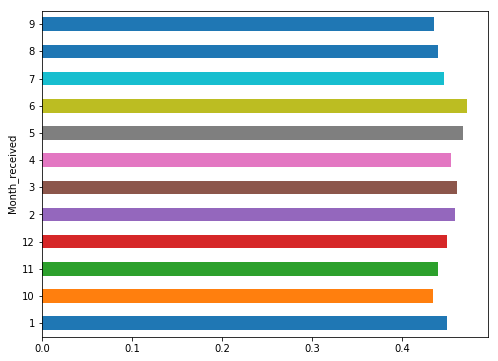

In [37]:
df.groupby('Month_received').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6))

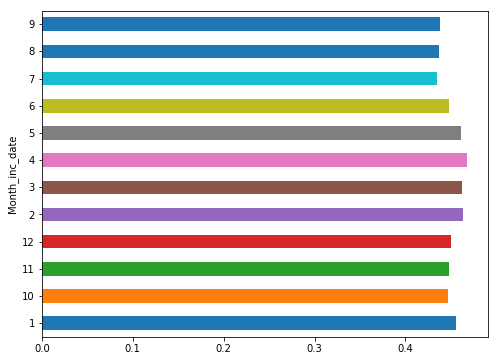

In [38]:
df.groupby('Month_inc_date').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

In [24]:
df.shape

(145421, 11)

In [10]:
df = df.dropna()

In [11]:
df.head()

,airport_code,airline,claim_type,claim_site,close_amount,disposition,item_category,binary_disposition,num_items_or_incidents_claimed,days_waited_to_file_claim,Month_received
0,MCO,Westjet Airlines Ltd,PropertyLoss,Checkpoint,17.990,Approve in Full,Household Items,Compensate,1,1,12
1,LAS,UAL,PropertyLoss,Checked Baggage,90.000,Settle,Clothing,Compensate,1,37,11
2,LAX,American Airlines,PropertyDamage,Checkpoint,485.550,Settle,Computer & Accessories,Compensate,1,51,11
3,FLL,Emirates,PropertyLoss,Checked Baggage,111.300,Approve in Full,Other,Compensate,1,15,10
4,MIA,American Airlines,PropertyLoss,Checked Baggage,65.000,Approve in Full,Baggage/Cases/Purses; Clothing,Compensate,2,161,10


In [12]:
X = df.drop(['binary_disposition', 'disposition', 
             #'date_received', 'incident_date',
             'close_amount',
            ]
            , axis=1)
y = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

In [13]:
X.head()

,airport_code,airline,claim_type,claim_site,item_category,num_items_or_incidents_claimed,days_waited_to_file_claim,Month_received
0,MCO,Westjet Airlines Ltd,PropertyLoss,Checkpoint,Household Items,1,1,12
1,LAS,UAL,PropertyLoss,Checked Baggage,Clothing,1,37,11
2,LAX,American Airlines,PropertyDamage,Checkpoint,Computer & Accessories,1,51,11
3,FLL,Emirates,PropertyLoss,Checked Baggage,Other,1,15,10
4,MIA,American Airlines,PropertyLoss,Checked Baggage,Baggage/Cases/Purses; Clothing,2,161,10


In [45]:
categorical = ['airport_code', 'airline', 'claim_type', 'claim_site', 'Month_received']
continuous =  ['days_waited_to_file_claim', 'num_items_or_incidents_claimed']

In [28]:
enc = OneHotEncoder(sparse=False)
onehotarray = enc.fit_transform(X[categorical])

ss = StandardScaler()
continuousarray = ss.fit_transform(X[continuous])

mlb = MultiLabelBinarizer(sparse_output=False)
onehot_itemcategories = mlb.fit_transform(X['item_category'].str.replace(' ','').str.split(pat=';'))

X = np.concatenate((onehotarray, continuousarray, onehot_itemcategories), axis=1)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [47]:
trans_dir = './models/transformers'

enc = OneHotEncoder(sparse=False)
enc.fit(X[categorical])
joblib.dump(enc, f'{trans_dir}/onehotencode.joblib')
# onehotarray = enc.transform(X[categorical])

ss = StandardScaler()
ss.fit(X[continuous])
joblib.dump(ss, f'{trans_dir}/standardscaler.joblib')


mlb = MultiLabelBinarizer(sparse_output=False)
mlb.fit(X['item_category'].str.replace(' ','').str.split(pat=';'))
joblib.dump(mlb, f'{trans_dir}/item_category.joblib')

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


['./models/transformers/item_category.joblib']

In [ ]:
# IT needs to be one entry in the master array. So like (1, 869)
# how do I get there? I need all the 869 features, and then I need to plug in the values as appropriate for the features I do have.

In [ ]:
# I think I need to take the big X with all the data, get its 869 feature array, then store the features for that.

# then with my example, I need to not fit_transform, but just transform it or something?!

In [19]:
model = joblib.load(open('./models/rf_full_month_rec', 'rb'))

In [21]:
example = {
  'airport_code': 'SEA',  # str
  'airline': 'Emirates',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Clothing',  # str
  'num_items_or_incidents_claimed': 1,  # int
  'days_waited_to_file_claim': 7, # int
  'Month_received': 1, # int (1-12)
}

Z = np.array([example['airport_code'],
                  int(example['airline'] == 'M'),
                  example['claim_type'],
                  example['claim_site'],
                  example['item_category'],
                  example['num_items_or_incidents_claimed'],
                  example['days_waited_to_file_claim'],
                  example['Month_received']]).reshape(1,-1)
prob_survived = model.predict_proba(X)[0, 1]

ValueError: could not convert string to float: 'MCO'

In [ ]:
np.array([features['airport_code'],
              int(features['airline'] == 'M'),
              features['claim_type'],
              features['claim_site'],
              features['item_category'],
              features['num_items_or_incidents_claimed'],
              features['days_waited_to_file_claim'],
              features['Month_received']]).reshape(1,-1)

In [55]:
categorical = ['airport_code', 'airline', 'claim_type', 'claim_site', 'Month_received']
X[categorical]

,airport_code,airline,claim_type,claim_site,Month_received
0,MCO,Westjet Airlines Ltd,PropertyLoss,Checkpoint,12
1,LAS,UAL,PropertyLoss,Checked Baggage,11
2,LAX,American Airlines,PropertyDamage,Checkpoint,11
3,FLL,Emirates,PropertyLoss,Checked Baggage,10
4,MIA,American Airlines,PropertyLoss,Checked Baggage,10
5,PHL,Southwest Airlines,PropertyLoss,Checked Baggage,10
6,IAD,UAL,PropertyLoss,Checked Baggage,10
7,PHX,Southwest Airlines,PropertyLoss,Checkpoint,10
8,EWR,-,PropertyDamage,Checkpoint,10
9,PHL,-,PropertyLoss,Checkpoint,10


In [60]:
pd.DataFrame(example, index =[0])

,airport_code,airline,claim_type,claim_site,item_category,num_items_or_incidents_claimed,days_waited_to_file_claim,Month_received
0,SEA,Emirates,PropertyLoss,Checkpoint,Clothing,1,7,1


In [148]:
def make_prediction(features):
    X = pd.DataFrame(data=features, index=[0])

    categorical = ['airport_code', 'airline', 'claim_type', 'claim_site', 'Month_received']
    continuous = ['days_waited_to_file_claim', 'num_items_or_incidents_claimed']

    trans_dir = './models/transformers'
    enc = joblib.load(f'{trans_dir}/onehotencode.joblib')
    onehotarray = enc.transform(X[categorical])

    ss = joblib.load(f'{trans_dir}/standardscaler.joblib')
    continuousarray = ss.transform(X[continuous])

    mlb = joblib.load(f'{trans_dir}/item_category.joblib')
    onehot_itemcategories = mlb.transform(X['item_category'].str.replace(' ', '').str.split(pat=';'))

    X = np.concatenate((onehotarray, continuousarray, onehot_itemcategories), axis=1)
    
    prob_receive_compensation = model.predict_proba(X)[0, 1]

    result = {
        'compensation': int(prob_receive_compensation > 0.5),
        'prob_receive_compensation': prob_receive_compensation
    }
    return result

In [149]:
example = {
  'airport_code': 'ATL',  # str
  'airline': 'Southwest Airlines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Computers',  # str
  'num_items_or_incidents_claimed': 1,  # int
  'days_waited_to_file_claim':15, # int
  'Month_received': '10', # int (1-12)
}

In [150]:
make_prediction(example)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:930: UserWarning: unknown class(es) ['Computers'] will be ignored
  .format(sorted(unknown, key=str)))


{'compensation': 0, 'prob_receive_compensation': 0.42149469724065525}

In [29]:
df = None

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [32]:
X.shape

(145421, 869)

# Model with Year included

---
some problems with this would be introducing YEAR and MONTH that has never been trained on. Is this where I need to do a timeseries thing

---

In [33]:
rf = RandomForestClassifier(random_state=42)

criterions = ['gini']#, 'entropy']
n_ests = [300]
m_depths = [20, 25, 30]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests, max_depth=m_depths)

grid_rf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=8, n_jobs=4)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

y_pred = grid_rf.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.7056302032660803
{'criterion': 'gini', 'max_depth': 30, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.6033733117354854


In [34]:
dir = 'models'
joblib.dump(grid_rf.best_estimator_, f'{dir}/rf_full_month_rec',compress=9)

['models/preliminary/rf_full_month_rec']

In [41]:
model.predict_proba()

ValueError: Expected 2D array, got scalar array instead:
array=3.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.